In [ ]:
import numpy as np
import pandas as pd
from queue import Queue
import threading
from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [44]:
class KNN:
    def __init__(self, num_threads):
        self.time = None
        self.y_train = None
        self.X_train = None
        self.k = None
        self.queue = None
        self.predictions = None
        self.num_threads = num_threads

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, k_neighbours):
        self.k = k_neighbours
        # Se inicializa el arreglo de predicciones con ceros utilizando el numero de filas de X
        self.predictions = np.zeros(X.shape[0])
        self.queue = Queue()
        # Se agrega a la cola los indices y los valores de X
        for i in range(X.shape[0]):
            self.queue.put((i, X[i, :]))
        threads = []
        for _ in range(self.num_threads):
            thread = threading.Thread(target=self.thread_predict)
            thread.start()
            threads.append(thread)

        for thread in threads:
            thread.join()

        return self.predictions

    def thread_predict(self):
        while not self.queue.empty():
            # Se obtiene el indice y el valor de X
            i, x = self.queue.get()
            distances = distance.cdist([x], self.X_train, 'euclidean').flatten()
            # Se obtienen los indices de los k vecinos mas cercanos
            k_indices = distances.argsort()[:self.k]
            # Se obtienen las etiquetas de los k vecinos mas cercanos
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            # Se obtiene la etiqueta mas repetida
            self.predictions[i] = max(set(k_nearest_labels), key=k_nearest_labels.count)

In [45]:
train_df = pd.read_csv('./dataset/trn_set.csv').dropna()
test_df = pd.read_csv('./dataset/tst_set.csv').dropna()

# split data into X and y (features and target)
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

In [55]:
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17]
thread_values = [3]
time_values = {}
colors = ['red', 'blue', 'green', 'orange']

for threads in thread_values:
    knn = KNN(threads)
    knn.fit(X_train, y_train)
    start = time.time()
    for k in k_values:
        y_pred = knn.predict(X_test, k)
        print('Threads: {}, K: {}, Accuracy: {}'.format(threads, k, accuracy_score(y_test, y_pred)))
    end = time.time()
    time_values[threads] = end - start


Threads: 3, K: 1, Accuracy: 0.9422668468816374
Threads: 3, K: 3, Accuracy: 0.9530797451245414
Threads: 3, K: 5, Accuracy: 0.9569414944970072
Threads: 3, K: 7, Accuracy: 0.9577138443715003
Threads: 3, K: 9, Accuracy: 0.9590654566518633
Threads: 3, K: 11, Accuracy: 0.9590654566518633
Threads: 3, K: 13, Accuracy: 0.9581000193087469
Threads: 3, K: 15, Accuracy: 0.9592585441204866
Threads: 3, K: 17, Accuracy: 0.9600308939949798


{5: 54.984997510910034, 7: 36.054619789123535, 9: 30.028111457824707, 11: 27.335660219192505}


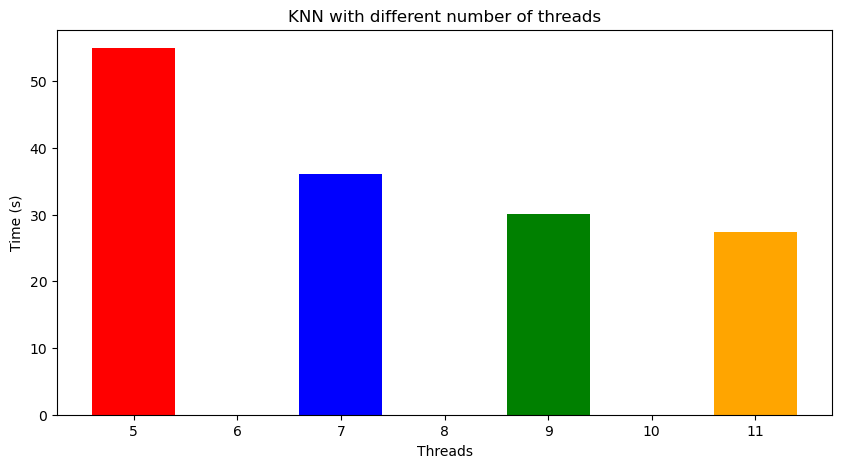

In [54]:
print(time_values)
plt.figure(figsize=(10, 5))
plt.bar(time_values.keys(), time_values.values(), color=colors)
plt.xlabel('Threads')
plt.ylabel('Time (s)')
plt.title('KNN with different number of threads')
plt.show()